## M2 - Model prediksi titik panas di Sumatera Selatan 2001 - 2023

In [1]:
# load all functions
from C01_data_collection import *
from C02_visualization import *
from C03_preprocessing import *
from C04_model_predictions import *
from C05_model_evaluate import *

- config models

In [2]:
# set random number
import random as rm
rm.seed(1234)

# set random number
import numpy as np
np.random.seed(1234)

# set random number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Data Collections

In [3]:
# load dataset
dataset = data_hotspot("dataset_enso.csv")
print(dataset.tail(3))

      acq_date  hotspot  sst_anom  oni_anom  soi_anom
273 2023-10-31     3200      1.59      1.78      -0.8
274 2023-11-30      390      1.90      1.92      -1.3
275 2023-12-31       42      1.99      1.97      -0.4


### 2. Data Preprocessing

In [4]:
# prosess normalization min-max
scaler, scaled = normalized(dataset, ["hotspot", "sst_anom", "oni_anom", "soi_anom"])

In [5]:
# hasil normalisasi data
np.round(scaled[:3],5)

array([[-1.     , -0.61485, -0.5514 ,  0.36   ],
       [-0.99972, -0.52204, -0.47664,  0.6    ],
       [-0.99903, -0.43387, -0.43925,  0.34   ]])

### 3. Pembagian Data

In [6]:
# proses pembagian data
x_train, y_train, x_test, y_test = results_multivariate_supervised(scaled)

In [7]:
# cek dimensi data
print(x_train.shape, y_train.shape)

(216, 1, 4) (216,)


In [8]:
# cek dimensi data
print(x_test.shape, y_test.shape)

(59, 1, 4) (59,)


### 4. Algoritma LSTM-RNN

#### 4.1 SBi-LSTM-RNN

In [9]:
# call models LSTM
# param : algorithm, timestep, activation, optimizer, dropout
lstm_model = get_models(
  algorithm="SBi-LSTM", timestep=x_train, activation="relu", optimizer="rmsprop", dropout=0.20
)

In [10]:
# compile models
# param : model, batch_size, epochs, x_train, y_train, x_test, y_test
lstm_history, lstm_predictions = get_prediction(
  model=lstm_model, batch_size=32, epochs=1500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

Epoch 1/1500
7/7 [==============================] - 10s 194ms/step - loss: 0.9176 - mean_absolute_error: 0.9176 - mean_squared_error: 0.8664 - mean_absolute_percentage_error: 98.9113 - val_loss: 0.9330 - val_mean_absolute_error: 0.9330 - val_mean_squared_error: 0.8857 - val_mean_absolute_percentage_error: 97.4848
Epoch 2/1500
7/7 [==============================] - 0s 16ms/step - loss: 0.8994 - mean_absolute_error: 0.8994 - mean_squared_error: 0.8327 - mean_absolute_percentage_error: 97.0418 - val_loss: 0.9171 - val_mean_absolute_error: 0.9171 - val_mean_squared_error: 0.8562 - val_mean_absolute_percentage_error: 95.7753
Epoch 3/1500
7/7 [==============================] - 0s 12ms/step - loss: 0.8840 - mean_absolute_error: 0.8840 - mean_squared_error: 0.8049 - mean_absolute_percentage_error: 95.4236 - val_loss: 0.9019 - val_mean_absolute_error: 0.9019 - val_mean_squared_error: 0.8285 - val_mean_absolute_percentage_error: 94.1355
Epoch 4/1500
7/7 [==============================] - 0s 8ms/

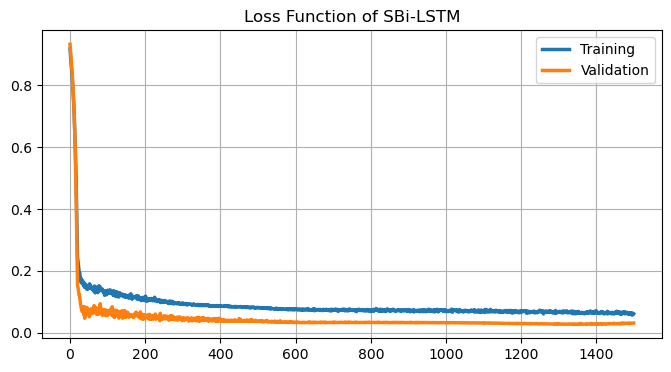

In [11]:
# show loss function
lineplot2(
  x1=lstm_history.epoch, y1=lstm_history.history['loss'], label1="Training",
  x2=lstm_history.epoch, y2=lstm_history.history['val_loss'], label2="Validation",
  title="Loss Function of SBi-LSTM"
)

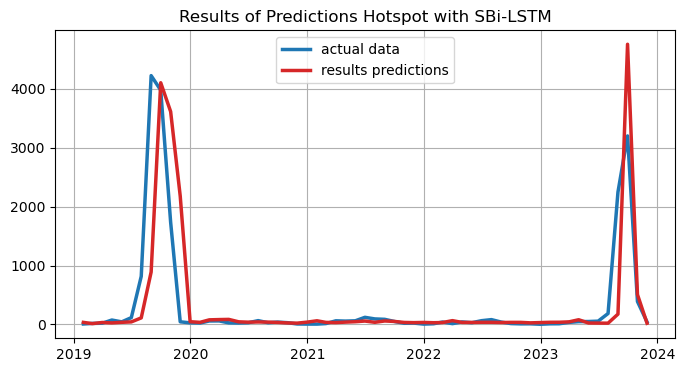

In [12]:
# show result predictions
scaler,_ = normalized(dataset, ["hotspot"])
lineplot3(
  x1=dataset["acq_date"].iloc[216:-1], y1=inverse(scaler, y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[216:-1], y2=inverse(scaler, lstm_predictions.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-LSTM"
)

In [13]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=y_test,
  ypred=lstm_predictions,
)

# results evaluate models
print("Evaluate Models with SBi-LSTM")
print("-----------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with SBi-LSTM
-----------------------------
R       : 0.7354
P-value : 0.0
MAE     : 0.0312
RMSE    : 0.0929
MAPE    : 0.0494


In [14]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, lstm_predictions.reshape(-1,1)),
)

# results evaluate models
print("Evaluate Models with SBi-LSTM")
print("-----------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape*100))

Evaluate Models with SBi-LSTM
-----------------------------
R       : 0.7354
P-value : 0.0
MAE     : 225.1575
RMSE    : 670.1032
MAPE    : 203.35999999999999


#### 4.2 SBi-LSTM-XGBoost

In [15]:
# call models XGBoost
lstm_xgb = get_XGBoost(
  xtrue=x_test, ytrue=y_test, ypred=lstm_predictions
)

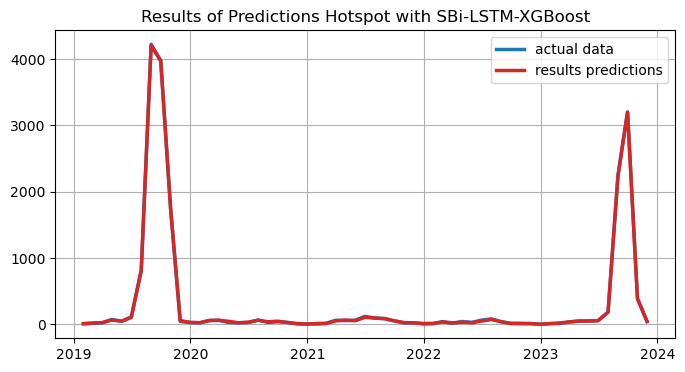

In [16]:
# show result predictions
scaler,_ = normalized(dataset, ["hotspot"])
lineplot3(
  x1=dataset["acq_date"].iloc[216:-1], y1=inverse(scaler, y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[216:-1], y2=inverse(scaler, lstm_xgb.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-LSTM-XGBoost"
)

In [17]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=y_test,
  ypred=lstm_xgb,
)

# results evaluate models
print("Evaluate Models with SBi-LSTM-XGBoost")
print("-------------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with SBi-LSTM-XGBoost
-------------------------------------
R       : 1.0
P-value : 0.0
MAE     : 0.0007
RMSE    : 0.001
MAPE    : 0.0008


In [18]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, lstm_xgb.reshape(-1,1)),
)

# results evaluate models
print("Evaluate Models with SBi-LSTM-XGBoost")
print("-------------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with SBi-LSTM-XGBoost
-------------------------------------
R       : 1.0
P-value : 0.0
MAE     : 5.2923
RMSE    : 6.995
MAPE    : 0.1927


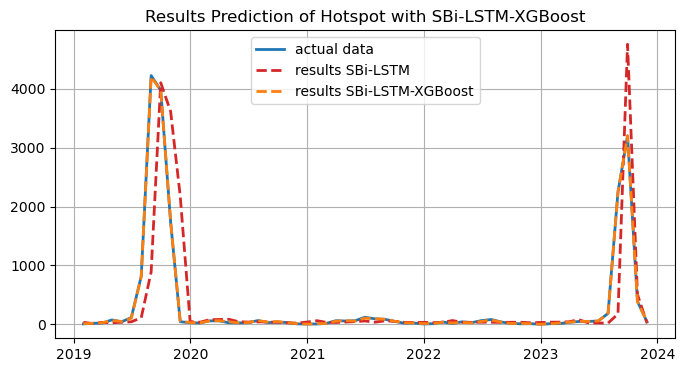

In [19]:
# show result predictions
lineplot4(

  # sumbu x
  date=dataset["acq_date"].iloc[216:-1],
  
  # data actual
  ytrue=inverse(scaler, y_test.reshape(-1,1)),

  # hasil SBi-LSTM
  ypred1=inverse(scaler, lstm_predictions.reshape(-1,1)),
  label1="results SBi-LSTM",
  
  # hasil SBi-LSTM-XGBoost
  ypred2=inverse(scaler, lstm_xgb.reshape(-1,1)),
  label2="results SBi-LSTM-XGBoost",

  # title plot
  title="Results Prediction of Hotspot with SBi-LSTM-XGBoost"
)

### 5. Algoritma GRU-RNN

#### 5.1 SBi-GRU-RNN

In [20]:
# call models GRU
# param : algorithm, timestep, activation, optimizer, dropout
gru_model = get_models(
  algorithm="SBi-GRU", timestep=x_train, activation="relu", optimizer="rmsprop", dropout=0.20
)

In [21]:
# compile models
# param : model, batch_size, epochs, x_train, y_train, x_test, y_test
gru_history, gru_predictions = get_prediction(
  model=gru_model, batch_size=16, epochs=1500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

Epoch 1/1500
14/14 [==============================] - 11s 109ms/step - loss: 0.8391 - mean_absolute_error: 0.8391 - mean_squared_error: 0.7284 - mean_absolute_percentage_error: 90.5289 - val_loss: 0.7759 - val_mean_absolute_error: 0.7759 - val_mean_squared_error: 0.6150 - val_mean_absolute_percentage_error: 80.8070
Epoch 2/1500
14/14 [==============================] - 0s 6ms/step - loss: 0.6905 - mean_absolute_error: 0.6905 - mean_squared_error: 0.5003 - mean_absolute_percentage_error: 74.9238 - val_loss: 0.5967 - val_mean_absolute_error: 0.5967 - val_mean_squared_error: 0.3676 - val_mean_absolute_percentage_error: 61.7099
Epoch 3/1500
14/14 [==============================] - 0s 6ms/step - loss: 0.4911 - mean_absolute_error: 0.4911 - mean_squared_error: 0.2668 - mean_absolute_percentage_error: 55.3495 - val_loss: 0.3575 - val_mean_absolute_error: 0.3575 - val_mean_squared_error: 0.1355 - val_mean_absolute_percentage_error: 36.8834
Epoch 4/1500
14/14 [==============================] - 0

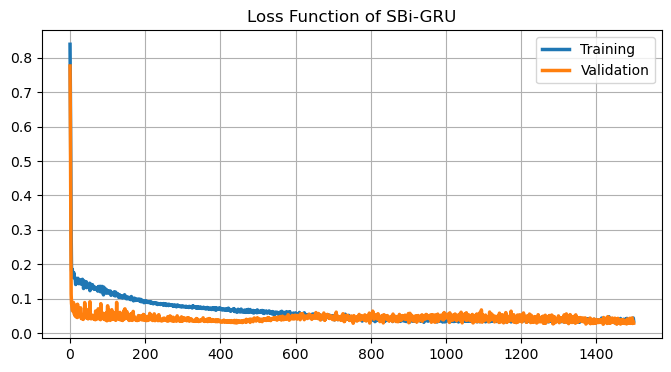

In [22]:
# show loss function
lineplot2(
  x1=gru_history.epoch, y1=gru_history.history['loss'], label1="Training",
  x2=gru_history.epoch, y2=gru_history.history['val_loss'], label2="Validation",
  title="Loss Function of SBi-GRU"
)


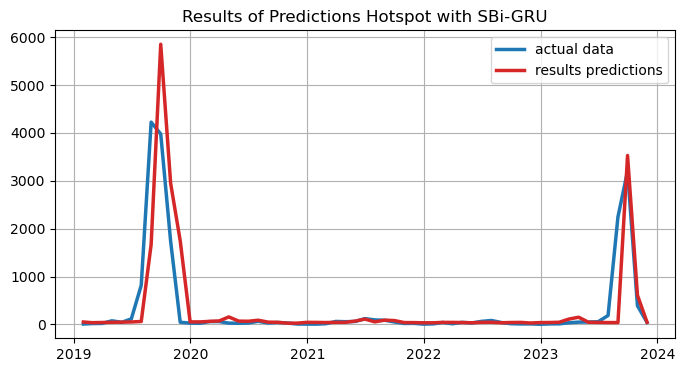

In [23]:
# show result predictions
scaler,_ = normalized(dataset, ["hotspot"])
lineplot3(
  x1=dataset["acq_date"].iloc[216:-1], y1=inverse(scaler, y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[216:-1], y2=inverse(scaler, gru_predictions.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-GRU"
)

In [24]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=y_test,
  ypred=gru_predictions,
)

# results evaluate models
print("Evaluate Models with SBi-GRU")
print("-----------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))


Evaluate Models with SBi-GRU
-----------------------------
R       : 0.8068
P-value : 0.0
MAE     : 0.0289
RMSE    : 0.0808
MAPE    : 0.0469


In [25]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, gru_predictions.reshape(-1,1)),
)

# results evaluate models
print("Evaluate Models with SBi-GRU")
print("-----------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape*100))

Evaluate Models with SBi-GRU
-----------------------------
R       : 0.8068
P-value : 0.0
MAE     : 208.5737
RMSE    : 583.3505
MAPE    : 204.82999999999998


#### 5.2 SBi-GRU-XGBoost

In [26]:
# call models XGBoost
gru_xgb = get_XGBoost(
  xtrue=x_test, ytrue=y_test, ypred=gru_predictions
)

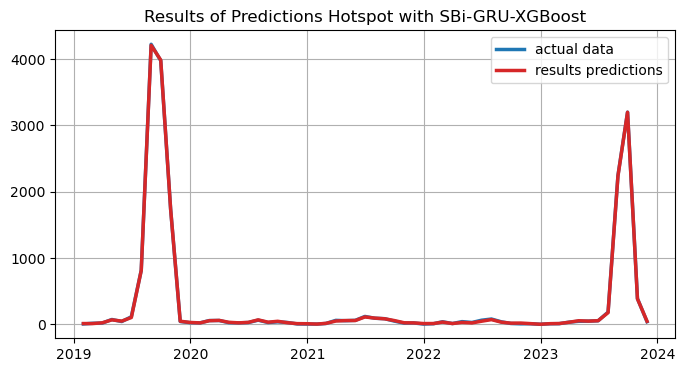

In [27]:
# show result predictions
scaler,_ = normalized(dataset, ["hotspot"])
lineplot3(
  x1=dataset["acq_date"].iloc[216:-1], y1=inverse(scaler, y_test.reshape(-1,1)), label1="actual data",
  x2=dataset["acq_date"].iloc[216:-1], y2=inverse(scaler, gru_xgb.reshape(-1,1)), label2="results predictions",
  title="Results of Predictions Hotspot with SBi-GRU-XGBoost"
)

In [28]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=y_test,
  ypred=gru_xgb,
)

# results evaluate models
print("Evaluate Models with SBi-GRU-XGBoost")
print("-------------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with SBi-GRU-XGBoost
-------------------------------------
R       : 1.0
P-value : 0.0
MAE     : 0.0007
RMSE    : 0.0008
MAPE    : 0.0008


In [29]:
# process evaluate models
r, p, mae, rmse, mape = evaluate_models(
  ytrue=inverse(scaler, y_test.reshape(-1,1)),
  ypred=inverse(scaler, gru_xgb.reshape(-1,1)),
)

# results evaluate models
print("Evaluate Models with SBi-GRU-XGBoost")
print("-------------------------------------")
print("R       : "+str(r))
print("P-value : "+str(p))
print("MAE     : "+str(mae))
print("RMSE    : "+str(rmse))
print("MAPE    : "+str(mape))

Evaluate Models with SBi-GRU-XGBoost
-------------------------------------
R       : 1.0
P-value : 0.0
MAE     : 4.8143
RMSE    : 6.0444
MAPE    : 0.176


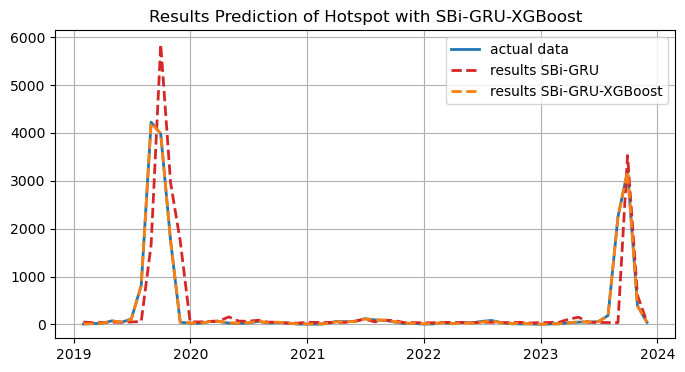

In [30]:
# show result predictions
lineplot4(

  # sumbu x
  date=dataset["acq_date"].iloc[216:-1],
  
  # data actual
  ytrue=inverse(scaler, y_test.reshape(-1,1)),

  # hasil SBi-GRU
  ypred1=inverse(scaler, gru_predictions.reshape(-1,1)),
  label1="results SBi-GRU",
  
  # hasil SBi-GRU-XGBoost
  ypred2=inverse(scaler, gru_xgb.reshape(-1,1)),
  label2="results SBi-GRU-XGBoost",

  # title plot
  title="Results Prediction of Hotspot with SBi-GRU-XGBoost"
)

### 6. Results Predictions Hotspot

In [31]:
# Results predictions
pd.concat([
  pd.DataFrame(np.array(dataset["acq_date"].iloc[217:]), columns=["Date"]),
  pd.DataFrame(np.round(inverse(scaler, y_test.reshape(-1,1)),0), columns=["Ytrue"]),
  pd.DataFrame(np.round(inverse(scaler, lstm_predictions.reshape(-1,1)),0), columns=["SBi-LSTM"]),
  pd.DataFrame(np.round(inverse(scaler, lstm_xgb.reshape(-1,1)),0), columns=["SBi-LSTM-XGBoost"]),
  pd.DataFrame(np.round(inverse(scaler, gru_predictions.reshape(-1,1)),0), columns=["SBi-GRU"]),
  pd.DataFrame(np.round(inverse(scaler, gru_xgb.reshape(-1,1)),0), columns=["SBi-GRU-XGBoost"]),
], axis=1).tail()
# 
# 
# #.to_csv("hasil prediksi titik panas M2.csv", index=False)

,Date,Ytrue,SBi-LSTM,SBi-LSTM-XGBoost,SBi-GRU,SBi-GRU-XGBoost
54,2023-08-31,186.0,22.0,184.0,39.0,179.0
55,2023-09-30,2247.0,175.0,2236.0,39.0,2239.0
56,2023-10-31,3200.0,4755.0,3202.0,3526.0,3199.0
57,2023-11-30,390.0,508.0,388.0,608.0,386.0
58,2023-12-31,42.0,20.0,46.0,46.0,48.0
